In [1]:
import pandas as pd

import config

In [2]:
config.REPO_ROOT

PosixPath('/home/users/skell/uor-msc-dissertation-xai-african-storms')

In [3]:
df = pd.read_csv(config.DATA_DIR / "East_Africa_tracked_MCSs_2014_2019_longer_than_3_hours.csv")
df.head()

,Storm,Life,Area,Initial UTC,Lon,Lat,Parent,Child,Accreted,u,...,LonInBounds,LatInBounds,in_domain,areaxgpm_mean,duration,duration_hr,speed,mean_speed,east_africa_time,eat_hours
0,3992,13,25,2014-01-02 14:15:00,38.900739,6.77762,[-999],[-999],[-999],0.15,...,True,True,True,NaN,0 days 03:15:00,3.25,2.134379,4.309462,2014-01-02 17:15:00,17.25
1,3992,13,40,2014-01-02 14:15:00,38.854092,6.77762,[-999],[-999],[-999],0.03,...,True,True,True,69.239998,0 days 03:15:00,3.25,4.353582,4.309462,2014-01-02 17:30:00,17.50
2,3992,13,52,2014-01-02 14:15:00,38.854092,6.77762,[-999],[-999],[-999],0.04,...,True,True,True,61.460004,0 days 03:15:00,3.25,0.901467,4.309462,2014-01-02 17:45:00,17.75
3,3992,13,68,2014-01-02 14:15:00,38.854092,6.77762,[-999],[-999],[-999],-1.03,...,True,True,True,NaN,0 days 03:15:00,3.25,7.018408,4.309462,2014-01-02 18:00:00,18.00
4,3992,13,81,2014-01-02 14:15:00,38.806765,6.74383,[-999],[-999],[-999],-0.54,...,True,True,True,NaN,0 days 03:15:00,3.25,3.344515,4.309462,2014-01-02 18:15:00,18.25


In [4]:
storm_inits = df.groupby("Storm").first()

/home/users/skell/.conda/envs/uor-msc-dissertation-xai-african-storms/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


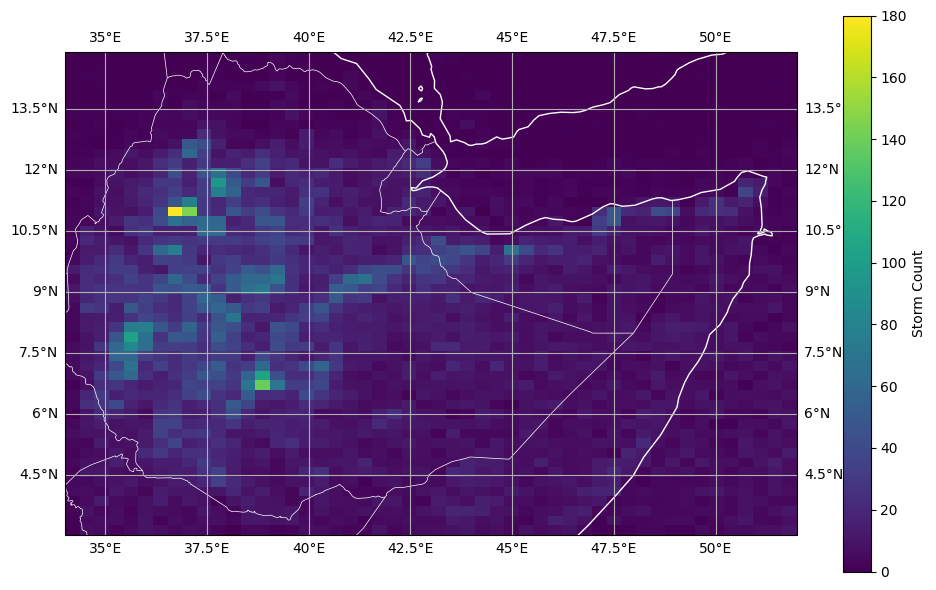

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='white', linewidth=1)
ax.add_feature(cf.BORDERS, color='white', linewidth=0.5)
ax.gridlines(draw_labels=True)
# https://www.julienphalip.com/blog/drawing-geographical-density-maps-with-matplotlib/
plt.hist2d(storm_inits["Lon"], storm_inits["Lat"], bins=50)
plt.colorbar(label='Storm Count')
plt.tight_layout()
plt.savefig(config.FIGURES_DIR/"storm_init_hist2d.png")
plt.show()

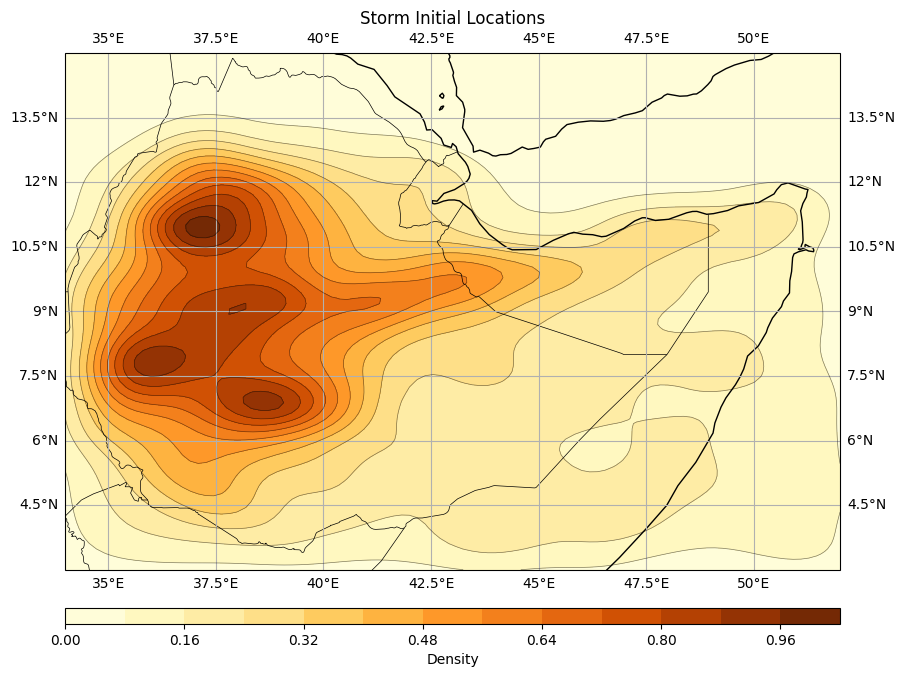

In [6]:
import numpy as np
from scipy.stats import gaussian_kde

# 2D kernel density estimation
xy = np.vstack([storm_inits["Lon"], storm_inits["Lat"]])
kde = gaussian_kde(xy)
xmin, xmax = config.DATA_EXTENT[0], config.DATA_EXTENT[1]
ymin, ymax = config.DATA_EXTENT[2], config.DATA_EXTENT[3]
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# normalize Z for consistent color scaling
Z /= Z.max()

# setup plot of east africa
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent(config.MAP_AREA_EXTENT, crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True)

# add filled contours and contour lines
ctf = ax.contourf(X, Y, Z, levels=15, cmap="YlOrBr")
ax.contour(X, Y, Z, levels=15, colors='k', linewidths=0.5, alpha=0.5)
cbar = plt.colorbar(ctf, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label("Density")

# Styling
ax.set_title("Storm Initial Locations")
plt.savefig(config.FIGURES_DIR/"storm_init_kde.png")
plt.show()

In [7]:
import xarray as xr

In [8]:
geop = xr.open_dataset(config.DATA_DIR/"std"/"geop.nc")

In [9]:
geop

<xarray.Dataset> Size: 21kB
Dimensions:     (valid_time: 1, latitude: 57, longitude: 89)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2019-12-31T12:00:00
  * latitude    (latitude) float64 456B 16.0 15.75 15.5 15.25 ... 2.5 2.25 2.0
  * longitude   (longitude) float64 712B 31.0 31.25 31.5 ... 52.5 52.75 53.0
Data variables:
    geop        (valid_time, latitude, longitude) float32 20kB ...
Attributes:
    data_source:        era5msc2025
    frequency:          d
    level_type:         sfc
    outfile_frequency:  day
    Conventions:        CF-1.7

In [10]:
geop["geop"].values.squeeze().shape

(57, 89)

In [11]:
import metpy.calc
from metpy.units import units

In [12]:
geop_vals = geop["geop"].values.squeeze()

# source: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.geopotential_to_height.html#metpy.calc.geopotential_to_height
geopot = units.Quantity(geop_vals, 'm^2/s^2')
height = metpy.calc.geopotential_to_height(geopot)
height

Magnitude,[[601.0414428710938 510.61590576171875 428.23895263671875 ... -2.2176332473754883 5.42147970199585 14.154818534851074] [590.79931640625 497.536376953125 418.35479736328125 ... 3.857248306274414 11.439016342163086 16.553552627563477] [578.1118774414062 498.7183837890625 422.88714599609375 ... -10.477717399597168 -11.277155876159668 -6.1562819480896] ... [1351.3681640625 853.931396484375 685.02685546875 ... 0.19025078415870667 -0.34549856185913086 0.07274440675973892] [1424.7471923828125 864.5616455078125 652.466796875 ... -0.39688271284103394 -0.7693181037902832 -0.7191289067268372] [1146.48388671875 767.3654174804688 738.0751342773438 ... -0.46539491415023804 0.26075461506843567 0.3109437823295593]]
Units,meter


In [13]:
storm_groups = df.sort_values(['Initial UTC']).groupby("Storm")

In [14]:
from utils import plotting

/home/users/skell/.conda/envs/uor-msc-dissertation-xai-african-storms/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


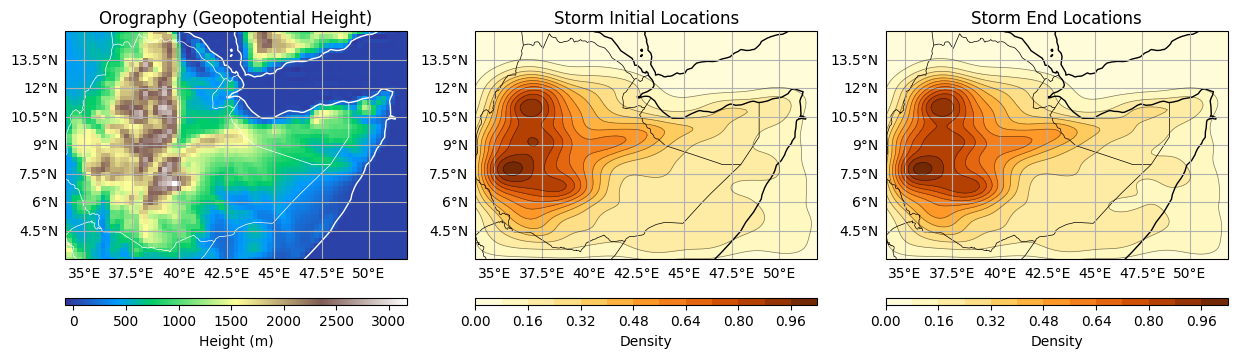

In [24]:
# create three subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# plot the orography
axs[0].coastlines(resolution='50m', color='white', linewidth=1)
axs[0].add_feature(cf.BORDERS, color='white', linewidth=0.5)
gl = axs[0].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
axs[0].set_extent(config.DATA_EXTENT, crs=ccrs.PlateCarree())
terrain = axs[0].pcolormesh(geop["longitude"], geop["latitude"], height, cmap='terrain', transform=ccrs.PlateCarree())
cbar = plt.colorbar(terrain, ax=axs[0], orientation='horizontal', pad=0.1, aspect=50)
cbar.set_label("Height (m)")
axs[0].set_title("Orography (Geopotential Height)")

storm_inits = storm_groups.first()
plotting.plot_kde_map(storm_inits["Lon"], storm_inits["Lat"], ax=axs[1], title="Storm Initial Locations")

storm_ends = storm_groups.last()
plotting.plot_kde_map(storm_ends["Lon"], storm_ends["Lat"], ax=axs[2], title="Storm End Locations")

plt.savefig(config.FIGURES_DIR/"orography_storm_init_end_kde.png")
plt.show()